# AutoRNN testing

In [1]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../Algoritmos')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Cargar SKAB data

In [2]:
path_to_data = '../data/'

all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

### Data description

In [4]:
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0


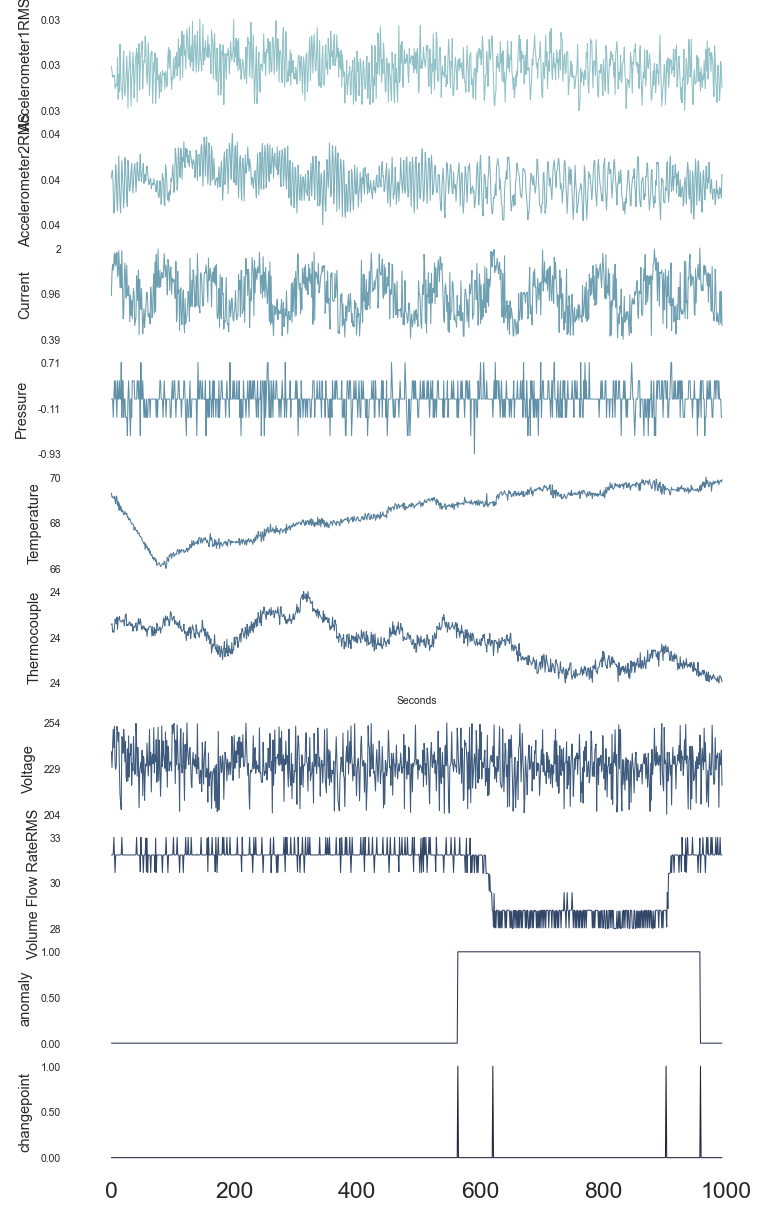

In [53]:
import seaborn as sns
def plot_cut(df, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        10, 1, dpi=150, figsize=(5, 8), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "Accelerometer1RMS",
        "Accelerometer2RMS",
        "Current",
        "Pressure",
        "Temperature",
        "Thermocouple",
        "Voltage",
        "Volume Flow RateRMS",
        "anomaly",
        "changepoint"
    ]

    # go through each of the signals
    for i in range(10):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,len(df)),
                     df[signals_trend[i]],
                     color=pal[i],
                     linewidth=0.5,
                     alpha=1)

        axis_label = signal_names_revised[i]

        # Mostrar valores en el eje Y
        y_values = df[signals_trend[i]].values
        y_ticks = np.linspace(y_values.min(), y_values.max(), num=3)  # Ajusta según tus datos
        y_ticklabels = ["{:.2f}".format(value) if value <= 1 else "{:.0f}".format(value) for value in y_ticks]
        axes[i].set_yticks(y_ticks)
        axes[i].set_yticklabels(y_ticklabels, fontsize=5)

        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            # axes[i].set_yticks([]) # also remove the y-ticks, cause ugly

        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            # axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)
            
data = list_of_df[33]
l = data.columns.tolist()
df = data
signals_trend = list(l) 

plot_cut(df, signals_trend, "cut_149")
# plt.savefig('cut_signals.png',format='png') # save the figure
plt.show()

## Evaluacion del modelo

In [54]:
from LSTM_AE import LSTM_AE 
from sklearn.preprocessing import StandardScaler
import numpy as np

In [55]:
# hyperparameters selection
EPOCHS = 100
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 30
Q = 0.99 # quantile for upper control limit (UCL) selection
PARAM = [EPOCHS, BATCH_SIZE, VAL_SPLIT]

model = LSTM_AE(PARAM)

In [56]:
# crear secuencias de entrada para el modelo
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


In [43]:
X.shape

(986, 10, 8)

In [57]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model fitting
    # history, model = arch(X)
    model.fit(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    UCL = residuals.quantile(Q) * 3/2
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)[1]), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > UCL
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

31/31 [==============================] - 1s 25ms/step
CPU times: total: 5min 52s
Wall time: 16min 28s


## Results

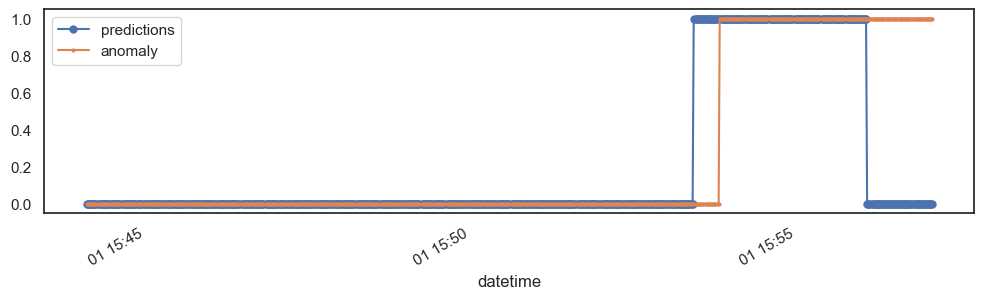

In [58]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend()

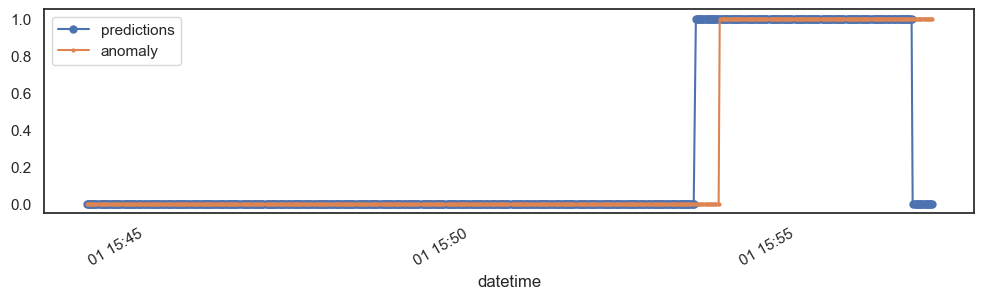

In [12]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend()

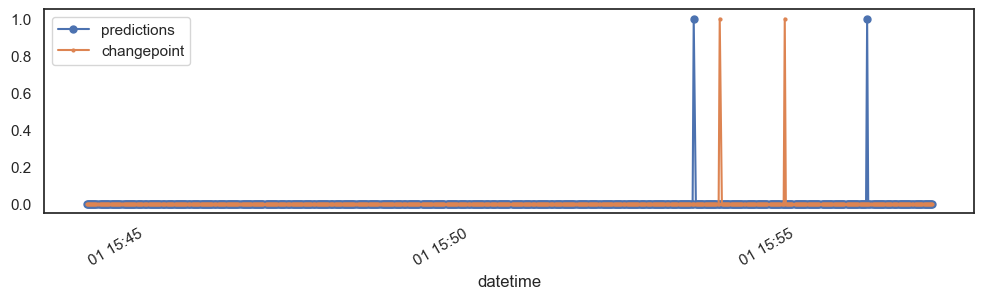

In [59]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()

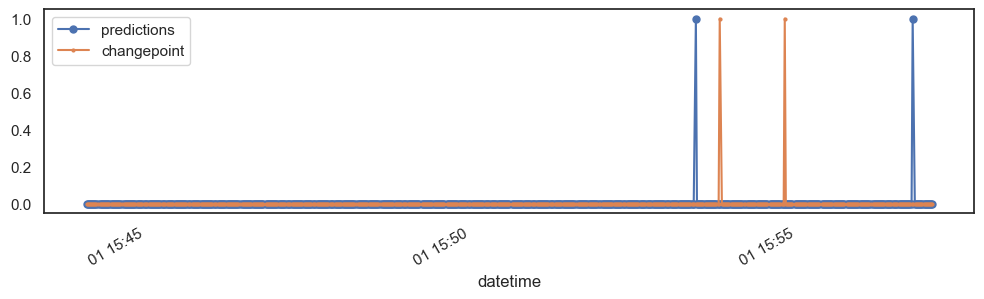

In [13]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()

## Métricas de evaluación

In [61]:
# %pip install tsad
from tsad.evaluating.evaluating import evaluating
from utils_functions import graficar_matriz_confusion

In [62]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 6.46 %
Missing Alarm Rate 43.96 %
F1 metric 0.67


In [19]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 14.12 %
Missing Alarm Rate 26.51 %
F1 metric 0.74


Since you not choose numenta_time and portion, then portion will be 0.1
TP 7323
TN 22761
FP 1573
FN 5744


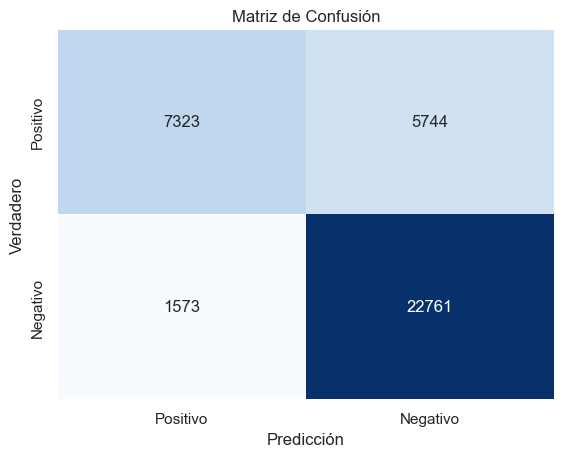

In [63]:
conf_matrix = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='confusion_matrix'
)
graficar_matriz_confusion(conf_matrix)

In [64]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [65]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-02-08 18:20:57'), Timestamp('2020-02-08 18:20:31'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:52'), Timestamp('2020-02-08 18:51:40'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:43'), Timestamp('2020-02-08 19:26:22'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:27'), Timestamp('2020-02-08 17:16:58'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:26'), Timestamp('2020-02-08 17:23:59'))
Standart  -  10.86
LowFP  -  7.4
LowFN  -  13.96
